### Merge of proximity data, amentity score, health indicators, DB aggregations, and COVID-19 data per PHU
---

In [232]:
import os
import numpy as np
import pandas as pd
import glob
import missingno as msno

---
### Import and Clean Data


In [233]:
# read data
prox = pd.read_csv('../data/PMD-en/PMD-on.csv')
qgis = pd.read_csv('../data/clean/qgis_phu.csv')
amenities = pd.read_csv('../data/clean/amenity_score_phu.csv')
covid = pd.read_csv('../data/clean/covid_wrangled.csv')
comorbidities = pd.read_csv('../data/clean/comorbidity_percent_phu.csv')

In [234]:
# only keep necessary columns
qgis = qgis[['fid', 'DBUID', 'PRUID', 'PRNAME', 'CSDUID', 'CSDNAME', 'CSDTYPE', 'CMAUID', 'CMAPUID', 
     'CMANAME', 'CMATYPE', 'HR_UID', 'ENG_LABEL', 'FRE_LABEL']]

In [235]:
# remove rows that don't have prox data ~ 141 rows removed
prox2 = prox[prox['prox_idx_emp'] != 'F']

# convert .. to np.nan
list_prox = ['prox_idx_emp', 'prox_idx_pharma', 'prox_idx_childcare',
            'prox_idx_health', 'prox_idx_grocery', 'prox_idx_educpri',
            'prox_idx_educsec', 'prox_idx_lib', 'prox_idx_parks',
            'prox_idx_transit']

for each in list_prox:
    prox2[each] = prox2[each].replace({"..":np.nan})

# convert to float
prox2[list_prox] = prox2[list_prox].astype(float)

//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()
//anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:2963: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


---
### Merge PHU covid data with PHU census data

In [236]:
# convert census type
covid['Census'] = 14570000

---
### Rename QGIS data HRs to PHUs given by Ontario Case Data


`Location` column in `covid` and `ENG_LABEL` in `qgis` represent PHU.

`Reporting_PHU` has different names.

In [237]:
# QGIS
qgis.rename(columns = {'ENG_LABEL' : 'Reporting_PHU'}, inplace = True)

In [238]:
# merge
merge = pd.merge(qgis, prox2, how = 'inner', on = 'DBUID')

In [239]:
# convert DBPOP to int
merge['DBPOP'] = merge['DBPOP'].str.replace(",", "")
merge['DBPOP'].replace({np.nan:0}, inplace = True)
merge['DBPOP'] = merge['DBPOP'].map(lambda x: int(x))

In [240]:
#merge[merge['DBPOP'].isna()]

### Missing data by DB

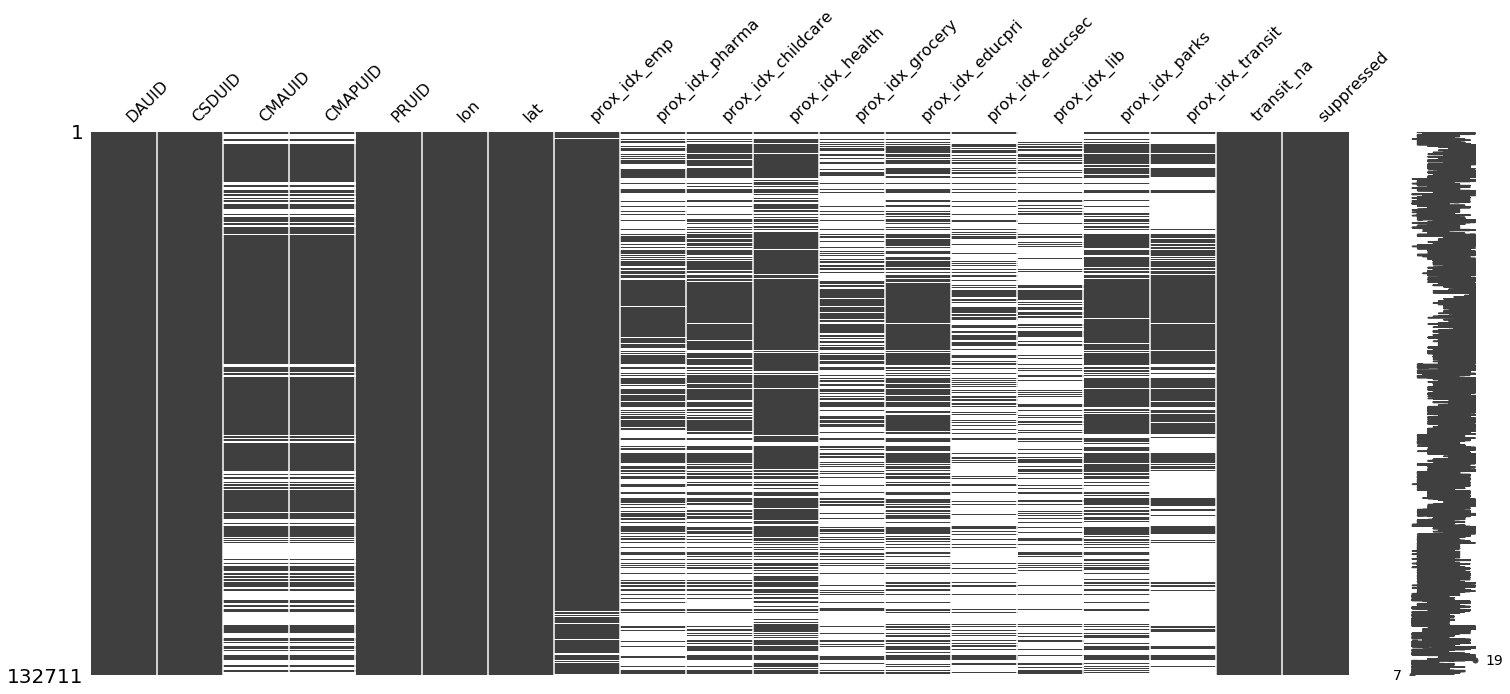

In [241]:
msno.matrix(prox2.groupby('DBUID').median())

In [242]:
# calc median of proximity per PHU
phu_med = merge.groupby('Reporting_PHU').median()

In [243]:
# convert DBPOP from median to sum
phu_med['DBPOP'] = merge.groupby('Reporting_PHU').sum()['DBPOP']

### Merge Amenity_Dense Data (proximity info)

In [244]:
amenities.rename(columns = {'Location':'Reporting_PHU'}, inplace= True)

In [245]:
phu_med = pd.merge(amenities, phu_med, on = "Reporting_PHU", how = 'inner')

**PHU CHECKS:**

In [246]:
len(list(phu_med.Reporting_PHU.unique()))

34

In [247]:
list(set(amenities.Reporting_PHU.unique())-set(phu_med.Reporting_PHU.unique()))

[]

In [248]:
list(set(phu_med.Reporting_PHU.unique())-set(amenities.Reporting_PHU.unique()))

[]

In [249]:
list(set(covid.Reporting_PHU.unique())-set(phu_med.Reporting_PHU.unique()))

[]

In [250]:
list(set(phu_med.Reporting_PHU.unique())-set(covid.Reporting_PHU.unique()))

[]

In [251]:
# merge covid with proximity/QGIS data
# covid.rename(columns = {'Reporting_PHU' : 'Location'}, inplace = True)
fullmerge = pd.merge(covid, phu_med, how = 'outer', on = 'Reporting_PHU')

In [252]:
fullmerge = fullmerge.groupby('Reporting_PHU').mean()

## Merge Comorbidity Data
---

In [253]:
comorbidities.rename(columns = {'phu_name':'Reporting_PHU'}, inplace = True)

In [254]:
master = pd.merge(fullmerge, comorbidities, how = 'outer', on = 'Reporting_PHU')

**Calculate proportions for COVID-19 case numbers:**


DBs were grouped by PHU and `DBPOP` (population of PHU) was summed.

<mark> $phu_{proportion} = \frac{cases}{phu_{pop}}$. </mark>

In [255]:
convert = ['FEMALE', 'MALE', 'TRANSGENDER', 'UNKNOWN', 'OTHER', 'CONTACT', 'NEITHER', 'TRAVEL-RELATED', 'NOT-RESOLVED',
          'RESOLVED', 'FATAL', 'TOTAL']

for c in convert:
    master[c+'prop'] = master[c]/master['DBPOP']
    

In [256]:
master['total_phu/ontario'] = master['TOTAL']/master['Census']

In [257]:
master.columns

Index(['Reporting_PHU', 'FEMALE', 'MALE', 'TRANSGENDER', 'UNKNOWN', 'OTHER',
       'CONTACT', 'NEITHER', 'TRAVEL-RELATED', 'NOT-RESOLVED', 'RESOLVED',
       'FATAL', 'youth', '20s', '30s', '40s', '50s', '60s', '70s', '80s',
       '90s', 'TOTAL', 'Census', 'Unnamed: 0', 'Unnamed: 0.1', 'amenity',
       'fid', 'DBUID', 'PRUID_x', 'CSDUID_x', 'CMAUID_x', 'CMAPUID_x',
       'HR_UID_x', 'DBPOP', 'DAUID', 'CSDUID_y', 'CMAUID_y', 'CMAPUID_y',
       'PRUID_y', 'lon', 'lat', 'prox_idx_emp', 'prox_idx_pharma',
       'prox_idx_childcare', 'prox_idx_health', 'prox_idx_grocery',
       'prox_idx_educpri', 'prox_idx_educsec', 'prox_idx_lib',
       'prox_idx_parks', 'prox_idx_transit', 'transit_na', 'suppressed',
       'HR_UID_y', 'Arthritis (15 years and over)', 'Asthma',
       'Body mass index, adjusted self-reported, adult (18 years and over), obese',
       'Body mass index, adjusted self-reported, adult (18 years and over), overweight',
       'Body mass index, self-reported, youth (12

In [258]:
# numeric columns to keep 
numeric_keep = ['DBPOP', 'Reporting_PHU', 'FEMALE', 'MALE', 'TRANSGENDER', 
                'UNKNOWN', 'OTHER', 'CONTACT', 'NEITHER', 'TRAVEL-RELATED', 'NOT-RESOLVED', 'RESOLVED', 'FATAL',
               'TOTAL', 'Census', 'fid', 'DBUID', 'PRUID_x', 'CSDUID_x', 'CMAUID_x', 'CMAPUID_x', 'HR_UID', 'DAUID',
               'lon', 'lat', 'prox_idx_emp', 'prox_idx_pharma', 'prox_idx_childcare', 'prox_idx_health', 
                'prox_idx_grocery', 'prox_idx_educpri', 'prox_idx_educsec', 'prox_idx_lib', 'prox_idx_parks', 
                'prox_idx_transit', 'amenity']

# proportion columns to keep
prop_keep = ['DBPOP', 'Reporting_PHU',
            'Census', 'HR_UID_x', 'FATAL', 'TOTAL','TOTALprop', 'FATALprop',
              'fid', 'DBUID', 'PRUID_x', 'CSDUID_x', 'CMAUID_x', 
             'CMAPUID_x', 'DAUID', 'lon', 'lat', 'prox_idx_emp', 'prox_idx_pharma', 'prox_idx_childcare', 
             'prox_idx_health', 'prox_idx_grocery', 'prox_idx_educpri', 'prox_idx_educsec', 'prox_idx_lib', 'prox_idx_parks', 
                'prox_idx_transit', 'amenity',
            'Arthritis (15 years and over)', 'Asthma',
       'Body mass index, adjusted self-reported, adult (18 years and over), obese',
       'Body mass index, adjusted self-reported, adult (18 years and over), overweight',
       'Body mass index, self-reported, youth (12 to 17 years old), overweight or obese',
       'Breast milk feeding initiation',
       'Chronic obstructive pulmonary disease (COPD; 35 years and over)',
       'Current smoker, daily', 'Current smoker, daily or occasional',
       'Diabetes', 'Exclusive breastfeeding, at least 6 months',
       'Has a regular healthcare provider', 'Heavy drinking',
       'High blood pressure', 'Influenza immunization in the past 12 months',
       'Life satisfaction, satisfied or very satisfied', 'Mood disorder',
       'Perceived health, fair or poor',
       'Perceived health, very good or excellent',
       'Perceived life stress, most days quite a bit or extremely stressful',
       'Perceived mental health, fair or poor',
       'Perceived mental health, very good or excellent',
       'Physical activity, 150 minutes per week, adult (18 years and over)',
       'Physical activity, average 60 minutes per day, youth (12 to 17 years old)',
       'Sense of belonging to local community, somewhat strong or very strong']

metadata_keep = ['HR_UID',
                'TOTALprop', 'FATALprop', 'NOT-RESOLVEDprop', 'RESOLVEDprop',
                'DBPOP', 'Reporting_PHU', 'CONTACTprop', 'TRAVEL-RELATEDprop', 'NEITHERprop']


In [259]:
master[prop_keep].columns

Index(['DBPOP', 'Reporting_PHU', 'Census', 'HR_UID_x', 'FATAL', 'TOTAL',
       'TOTALprop', 'FATALprop', 'fid', 'DBUID', 'PRUID_x', 'CSDUID_x',
       'CMAUID_x', 'CMAPUID_x', 'DAUID', 'lon', 'lat', 'prox_idx_emp',
       'prox_idx_pharma', 'prox_idx_childcare', 'prox_idx_health',
       'prox_idx_grocery', 'prox_idx_educpri', 'prox_idx_educsec',
       'prox_idx_lib', 'prox_idx_parks', 'prox_idx_transit', 'amenity',
       'Arthritis (15 years and over)', 'Asthma',
       'Body mass index, adjusted self-reported, adult (18 years and over), obese',
       'Body mass index, adjusted self-reported, adult (18 years and over), overweight',
       'Body mass index, self-reported, youth (12 to 17 years old), overweight or obese',
       'Breast milk feeding initiation',
       'Chronic obstructive pulmonary disease (COPD; 35 years and over)',
       'Current smoker, daily', 'Current smoker, daily or occasional',
       'Diabetes', 'Exclusive breastfeeding, at least 6 months',
       'Has a 

In [260]:
master[prop_keep].to_csv('../data/clean/PHU_master_prop.csv')
# fullmerge[numeric_keep].to_csv('../data/clean/PHU_FINAL_num.csv')

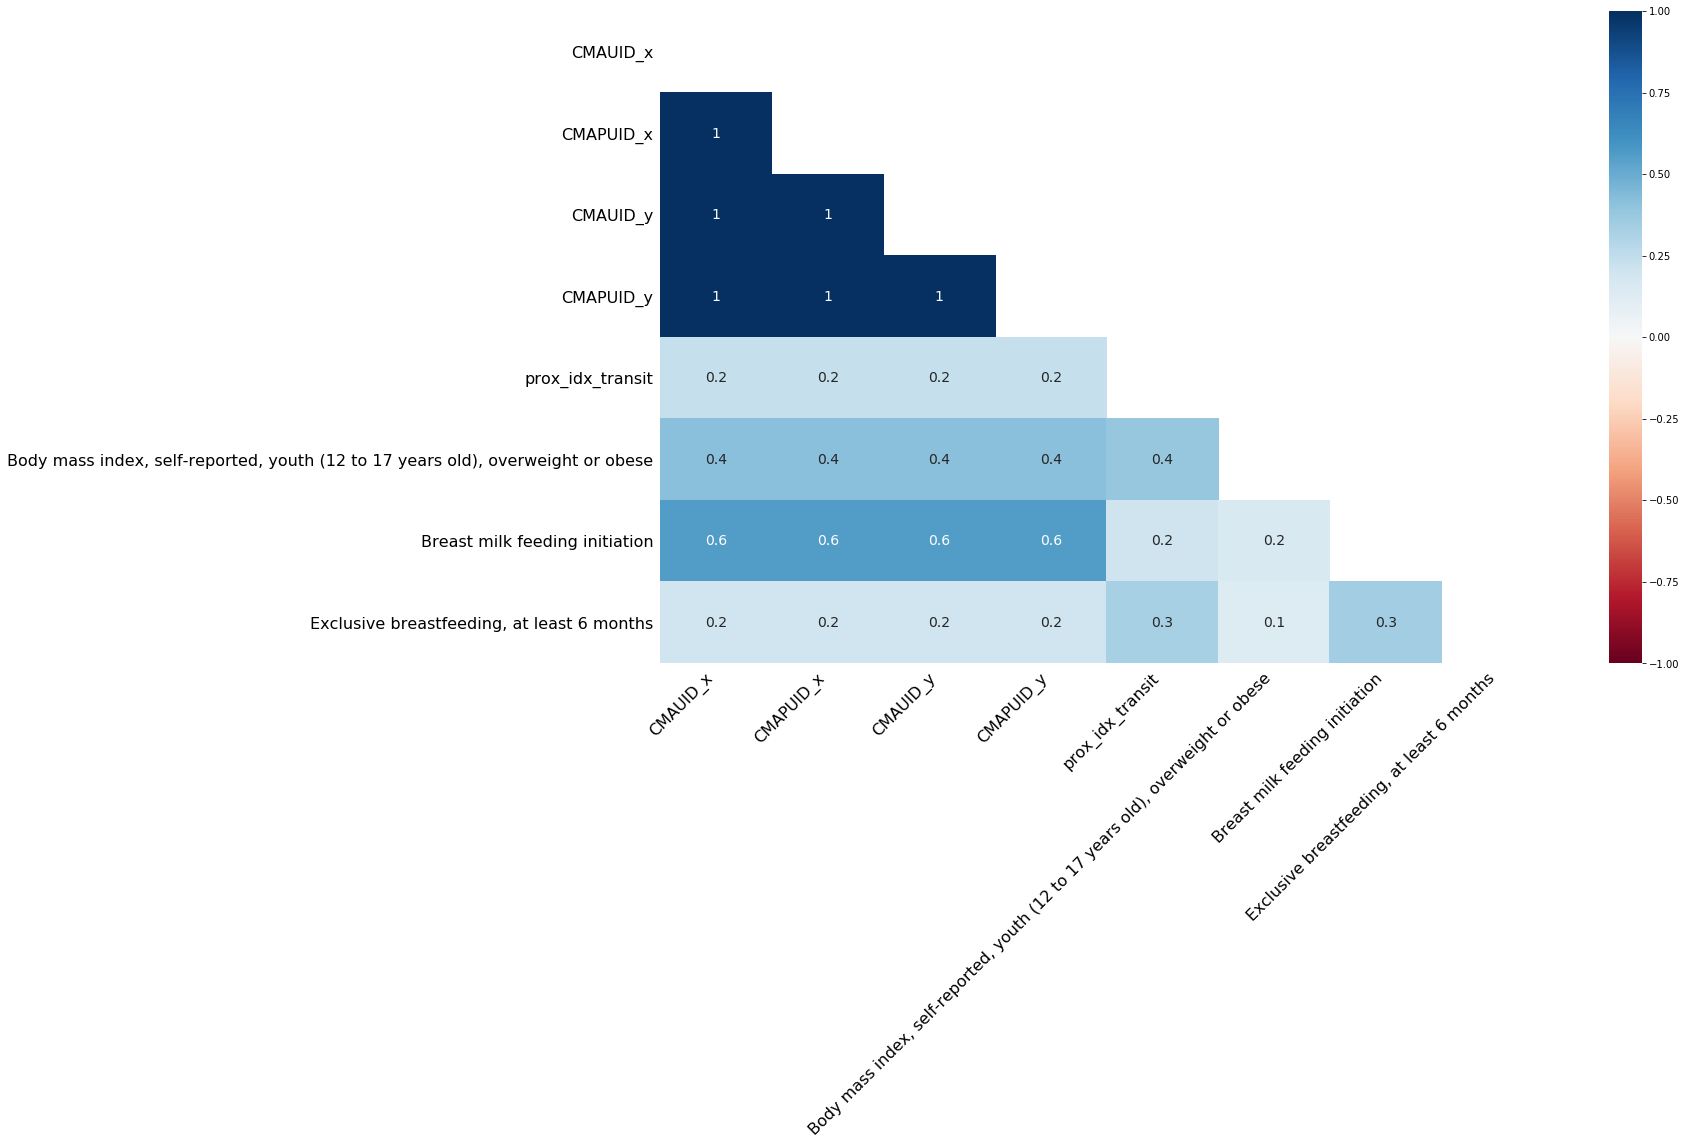

In [261]:
msno.heatmap(master)